
# 16124278 王浩 Week 3 
## Cifar10图像分类

由于Cifar10数据集较大，且本文中的训练模型的总参数多达142万，

即使在本地使用GPU（MX150）训练，每次运行仍需接6-8小时，不利于程序的后续调整，

故本程序借助Google Colab（约30min-1h）利用GPU加速在云端运行。

最终模型在（最佳的一次参数：batch=256,factor=0.1,patience=5,62s, 35epoch）

训练集上的准确率为：99.78%

验证集上的准确率为：97.15%   

**测试集上的准确率为：97.07%**

*在几大经典图像识别数据集（MNIST / CIFAR10 / CIFAR100 / STL-10 / SVHN / ImageNet）中，*

*对于 CIFAR10 数据集而言，目前业内 State-of-Art 级别的模型所能达到的最高准确率是 96.53%。*

*注：由于暂时无法在Colab中引用本地图片，本文中所有图片均已上传至GitHub，用网络链接的形式进行展示。*

[本地图片链接（GitHub）](https://github.com/MirstT/Colab_Cifar10_Image-recognition/tree/master/res)

[本程序所有历史训练数据](https://github.com/MirstT/Colab_Cifar10_Image-recognition.git)

## 打印Colab目前连接使用的机器（GPU）信息


In [2]:
# 检查并安装第三官方库
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

#打印相关信息
printm()

Gen RAM Free: 13.0 GB  | Proc size: 114.5 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


## 建立Ipynb与Google云盘的连接

将训练所得模型以及日志文件储存在自己的云盘文件中，同时方便以后使用云盘上的本地数据集/本地模板库。

![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/WH_2019-04-09_08-08-39.png?raw=true)

**登录代码：**（一次性）

![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/WH_2019-04-09_16-14-21.png?raw=true)

In [4]:
# 安装相关文件
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# 账号信息授权
from google.colab import auth
auth.authenticate_user()
#授权码1
#4/JwE_0WWiynLrN7mj3bfRDFe6R4jhjc2hKcSb59vXE816ZAyt2kCyjXM

# 账号密码授权
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
#授权码2
#4/JwHPn1brf-kYZU5L6pmu4XsF7Ckdhs-h9aXh93BLCYk-bMQKa1r-dks

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

## Google云盘工作文件夹设置
显示工作目录下的内容（和linux系统下命令基本相同）

ubuntu18.04.1

![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/WH_2019-04-09_15-36-19.png?raw=true)


In [5]:
# 指定Google Drive云端硬盘的根目录，名为wh_drive
!mkdir -p wh_drive
!google-drive-ocamlfuse wh_drive


# 指定当前的工作文件夹
import os
os.chdir("wh_drive/Colab") 


# 显示工作目录下的内容
! ls 

Advanced_Data_Analysis	mnist_mlp.ipynb		     WH_2019-04-09_08-08-39.png
char-09.ipynb		models
logs			old_Cifar_10_图像识别.ipynb


## Cifar10数据集介绍
该数据集共有60000张彩色图像，这些图像是32*32，分为10个类，每类6000张图。这里面有50000张用于训练，构成了5个训练批，每一批10000张图；另外10000用于测试，单独构成一批。测试批的数据里，取自10类中的每一类，每一类随机取1000张。抽剩下的就随机排列组成了训练批。注意一个训练批中的各类图像并不一定数量相同，总的来看训练批，每一类都有5000张图。
  
下面这幅图就是列举了10各类，每一类展示了随机的10张图片：
  
  ![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/Cifar10%E6%95%B0%E6%8D%AE%E9%9B%86.png?raw=true)
  
## Cifar10数据集下载
服务器网速很快(6-10MB/s)，不需要从云盘中读取数据集，直接下载到Colab服务器运行即可

In [6]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#设置随机种子
np.random.seed(161)

from keras.datasets import cifar10

#读取数据集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#归一化
x_train = x_train / 255.0
x_test = x_test / 255.0

Using TensorFlow backend.


170500096/170498071 [==============================] - 26s 0us/step


## Cifar10数据预处理
将彩色图片转为灰度图片：
灰度值 = 0.2989 * 红色 + 0.5870 * 绿色 + 0.1140 * 蓝色


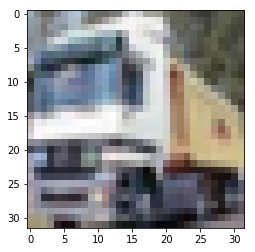

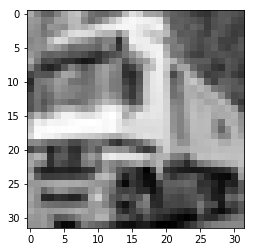

In [7]:
#选取彩色通道，将图片转换为灰度图
x_train_gray = np.dot(x_train[:,:,:,:3], [0.299, 0.587, 0.114])
x_test_gray = np.dot(x_test[:,:,:,:3], [0.299, 0.587, 0.114])

#大小统一为32*32像素
x_train_gray = x_train_gray.reshape(-1,32,32,1)
x_test_gray = x_test_gray.reshape(-1,32,32,1)

from keras.utils.np_utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

plt.imshow(x_train[1])
plt.show()

plt.imshow(x_train_gray[1,:,:,0], cmap='gray')
plt.show()

## 模型搭建（基于Inception网络）

### Inception网络是对传统CNN网络的改进
在 Inception 出现之前，大部分流行 CNN 仅仅是把卷积层堆叠得越来越多，使网络越来越深，以此希望能够得到更好的性能。

**但问题是：图像中突出部分的大小差别很大。**

例如，狗的图像可以是以下任意情况。每张图像中狗所占区域都是不同的。

![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/%E4%B8%8D%E5%90%8C%E5%8D%B7%E7%A7%AF%E6%A0%B8%E7%9A%84%E5%BF%85%E8%A6%81%E6%80%A7.jpg?raw=true)

从左到右：狗占据图像的区域依次减小（[图源](https://unsplash.com/)）。

* 由于信息位置的巨大差异，为卷积操作选择合适的卷积核大小就比较困难。

* 信息分布更全局性的图像偏好较大的卷积核，信息分布比较局部的图像偏好较小的卷积核。

* 非常深的网络更容易过拟合。将梯度更新传输到整个网络是很困难的。

* 简单地堆叠较大的卷积层非常消耗计算资源。





**获得高质量模型最保险的做法就是增加模型的深度（层数）或者是其宽度（层核或者神经元数），**

但是一般设计思路的情况下会出现如下的缺陷：

* 参数太多，若训练数据集有限，容易过拟合；

* 网络越大计算复杂度越大，难以应用；

* 网络越深，梯度越往后穿越容易消失，难以优化模型。


解决上述两个缺点的根本方法是将全连接甚至一般的卷积都转化为稀疏连接。为了打破网络对称性和提高

学习能力，传统的网络都使用了随机稀疏连接。但是，计算机软硬件对非均匀稀疏数据的计算效率很差，

所以在本模型中重新**启用了全连接层，目的是为了更好地优化并行运算**。

### Inception架构的主要思想是找出如何用密集成分来近似最优的局部稀疏结。
![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/Inception%E6%9E%B6%E6%9E%84.jpg?raw=true)

* 采用不同大小的卷积核意味着不同大小的感受野，最后拼接意味着不同尺度特征的融合；
* 之所以卷积核大小采用1x1、3x3和5x5，主要是为了方便对齐。设定卷积步长stride=1之后，只要分别设定padding =0、1、2，采用same卷积可以得到相同维度的特征，然后这些特征直接拼接在一起； 
* 很多论文都表明pooling挺有效，所以Inception里面也嵌入了pooling。
* 在 3x3 和 5x5 卷积层之前添加额外的 1x1 卷积层，实现跨通道的交互和信息整合并限制输入信道的数量（降维）减少计算成本。

所有子层的输出最后会被级联起来，并传送至下一个 Inception 模块。

**Inception的作用：代替人工确定卷积层中的过滤器类型或者确定是否需要创建卷积层和池化层，**即：不需要人为的决定使用哪个过滤器，是否需要池化层等，由网络自行决定这些参数，可以给网络添加所有可能值，将输出连接起来，网络自己学习它需要什么样的参数。






In [18]:
import datetime # 输出模型日期后缀

from keras.layers import Flatten, Activation, Conv2D, MaxPool2D, AvgPool2D, Dense, Dropout, BatchNormalization, Input, MaxPooling2D, Flatten, Activation, Conv2D, AvgPool2D, Dense, Dropout, concatenate, AveragePooling2D
from keras.optimizers import Adam, SGD
from keras.models import Sequential
import keras.backend as K
from keras.regularizers import l1,l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.models import model_from_json, Model



# 自定义全连接层
def build_dense(input_layer, neurons_nr, dense_nr, 
                dropout=False, normalization=False, regularization='l2', dropout_ratio=0.5):
  
    dense = Dense(neurons_nr, kernel_regularizer=regularization, 
                  name='dense_%d_%d'%(dense_nr, neurons_nr))(input_layer)
    
    # 视条件而定 使用dropout/normalization
    if dropout:
        dense = Dropout(dropout_ratio, name='dense_%d_%ddrop'%(dense_nr, neurons_nr))(dense)
    if normalization:
        dense = BatchNormalization(name='dense_%d_%dnorm'%(dense_nr, neurons_nr))(dense) #Batch Normalization批量标准化
    
    return dense

  
  
# 构建一个Inception模型
def build_inception_module(input_layer, features_nr, module_nr, 
                           dropout=False, normalization=False, regularization='l2', dropout_ratio=0.2): 
  
    # feature_nr 是一个用来构建一个inception内部网络层的数组
    # 其数据形式为: [1x1, 3x3 reduce, 3x3, 5x5 reduce, 5x5, pool proj]
    
    # 1*1 卷积核  
    inception_1x1 = Conv2D(features_nr[0],1,1,border_mode='same',activation='relu',name='inception_%d_/1x1'%(module_nr),W_regularizer=l2(0.0002))(input_layer)
    
    # 1. 实现跨通道的交互和信息整合；2. 进行卷积核通道数的降维
    inception_3x3_reduce = Conv2D(features_nr[1],1,1,border_mode='same',activation='relu',name='inception_%d_/3x3_reduce'%(module_nr),W_regularizer=l2(0.0002))(input_layer) 
    
    # 3*3 卷积核
    inception_3x3 = Conv2D(features_nr[2],3,3,border_mode='same',activation='relu',name='inception_%d_/3x3'%(module_nr),W_regularizer=l2(0.0002))(inception_3x3_reduce)
    
    # 1. 实现跨通道的交互和信息整合；2. 进行卷积核通道数的降维
    inception_5x5_reduce = Conv2D(features_nr[3],1,1,border_mode='same',activation='relu',name='inception_%d_/5x5_reduce'%(module_nr),W_regularizer=l2(0.0002))(input_layer)
    
    # 5*5 卷积核
    inception_5x5 = Conv2D(features_nr[4],5,5,border_mode='same',activation='relu',name='inception_%d_/5x5'%(module_nr),W_regularizer=l2(0.0002))(inception_5x5_reduce)
    
    # max pooling 核
    inception_pool = MaxPooling2D(pool_size=(3,3),strides=(1,1),border_mode='same',name='inception_%d_/pool'%(module_nr))(input_layer)
    
    # 1. 实现跨通道的交互和信息整合；2. 进行卷积核通道数的降维
    inception_pool_proj = Conv2D(features_nr[5],1,1,border_mode='same',activation='relu',name='inception_%d_/pool_proj'%(module_nr),W_regularizer=l2(0.0002))(inception_pool)
    
    # inception 输出
    inception_output = concatenate([inception_1x1,inception_3x3,inception_5x5,inception_pool_proj],axis=3,name='inception_%d_/output'%(module_nr))

    # 视条件而定 使用dropout/normalization
    if dropout:
        inception_output = Dropout(dropout_ratio, name='inception_%d_/output_drop'%(module_nr))(inception_output)
    if normalization:
        inception_output = BatchNormalization(name='inception_%d_/output_norm'%(module_nr))(inception_output)
    
    # maxpooling层最终输出（2*2）
    pooled = MaxPooling2D((2,2), padding='same', name='inception_%d_2x2subsample'%(module_nr))(inception_output)
    
    return pooled

#模型名称
i='cifar10-nrcrt7-'+datetime.datetime.now().strftime("%I:%M%p_%B-%d-%Y")

K.clear_session()

#在Google云盘创建储存模型与日志的文件夹（工作目录下创建）
!mkdir -p models
!mkdir -p logs

a = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')#如果验证集loss值连续10个周期不下降，程序自动停止（早停法）
b = ModelCheckpoint(monitor='val_loss', filepath='./models/'+str(i)+'.hdf5', verbose=1, save_best_only=True)#每个训练周期后，验证集loss值如果下降，则储存改模型（最终只储存最好的模型）
c = TensorBoard(log_dir='./logs/'+str(i),
                write_grads=True,
                write_graph=True,
                write_images=True,
                batch_size=256)#保存日志文件至Google云盘中

#回调函数：当评价指标（验证集loss值）不在提升时，减少学习率 （loss值连续patience次没有变化时，学习率缩小为factor倍）
d = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[a,b,c,d]

#------------模型定义-------------------

use_norm = True #使用BN
lrate = 0.001 #学习率

input_img = Input(shape = (32, 32, 3), name='input') #数据输入

inception_1 = build_inception_module(input_img, [64,96,128,16,32,32], 1, False, use_norm) #inception_1

inception_2 = build_inception_module(inception_1, [128,128,192,32,96,64], 2, False, use_norm)#inception_2

inception_3 = build_inception_module(inception_2, [192,96,208,16,48,64], 3, False, use_norm)#inception_3

inception_4 = build_inception_module(inception_3, [160, 112, 224, 24, 64, 64], 4, False, use_norm)#inception_4

flat_pool = AveragePooling2D(pool_size=(2, 2), padding='valid')(inception_4) #平均池化

flat = Flatten()(flat_pool)

dense_5 = build_dense(flat, 128, 1, True, use_norm) # 全连接层

dense_6 = build_dense(dense_5, 64, 2, True, use_norm) # 全连接层

out = Dense(10, activation='softmax')(dense_6) # 最后一层使用softmax激活函数

model = Model(inputs = input_img, outputs = out)# 输出

#-----------------------------------------------

model.compile(loss='binary_crossentropy', #二分类的损失函数
              optimizer=Adam(lrate),
              metrics=['accuracy']) #设置损失函数和优化器

model.summary()

#将模型转换为json文件
model_json = model.to_json()
with open("./models/"+str(i)+".json", "w") as json_file:
    json_file.write(model_json)

print("已将模型储存至" + "../models/"+str(i)+".json")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), activation="relu", name="inception_1_/1x1", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (1, 1), activation="relu", name="inception_1_/3x3_reduce", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="inception_1_/3x3", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (1, 1), activation="relu", name="inception_1_/5x5_reduce", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
inception_1_/3x3_reduce (Conv2D (None, 32, 32, 96)   384         input[0][0]                      
__________________________________________________________________________________________________
inception_1_/5x5_reduce (Conv2D (None, 32, 32, 16)   64          input[0][0]                      
__________________________________________________________________________________________________
inception_1_/pool (MaxPooling2D (None, 32, 32, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
inception_

## 模型可视化
本模型包含4个线性堆叠的Inception层，3层全连接层，

该模型在最后一个 inception 模块处使用了全局平均池化，最后一个全连接层输出时使用sofmax激活函数。

Dropout可有效防止过拟合的发生,但从深度学习的发展趋势看，Batch Normalizaton（BN）正在逐步取代Dropout技术，特别是在卷积层。

BN在准确率和损失率上表现要优于Dropout，故本文在Inception层采用了BN，在全连接层继续采用了Dropout。



![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/%E6%A8%A1%E5%9E%8B%E6%A1%86%E6%9E%B6.jpg?raw=true)

## 运行内存
模型运行时内存统计（参数）。

In [19]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes
  
print("内存使用 (GB):", get_model_memory_usage(128,model))

内存使用 (GB): 1.47


## 模型训练
使用GPU加速训练过程，并将训练所得模型保存至Google云盘。

In [20]:
import tensorflow as tf

with tf.device('/gpu:0'):
  model.fit(x_train, y_train_cat, batch_size=256, epochs=100, validation_split=0.2,verbose=1,callbacks=callbacks)  # 开始训练 100个周期

  
  
result = model.evaluate(x_test, y_test_cat)

print("准确率（测试集）: ",result[1]*100,"%")

#将模型与日志拷贝至Google云盘
!cp -R models ./
!cp -R logs ./

print("已将模型与日志拷贝至Google云盘")

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 65s 2ms/step - loss: 1.3503 - acc: 0.9062 - val_loss: 0.6279 - val_acc: 0.9000

Epoch 00001: val_loss improved from inf to 0.62791, saving model to ./models/cifar10-nrcrt7-09:05AM_April-11-2019.hdf5
Epoch 2/100
40000/40000 [==============================] - 62s 2ms/step - loss: 0.4296 - acc: 0.9288 - val_loss: 0.4376 - val_acc: 0.9043

Epoch 00002: val_loss improved from 0.62791 to 0.43763, saving model to ./models/cifar10-nrcrt7-09:05AM_April-11-2019.hdf5
Epoch 3/100
40000/40000 [==============================] - 62s 2ms/step - loss: 0.3087 - acc: 0.9401 - val_loss: 0.3233 - val_acc: 0.9237

Epoch 00003: val_loss improved from 0.43763 to 0.32332, saving model to ./models/cifar10-nrcrt7-09:05AM_April-11-2019.hdf5
Epoch 4/100
40000/40000 [==============================] - 62s 2ms/step - loss: 0.2534 - acc: 0.9474 - val_loss: 0.2844 - val_acc: 0.9299

Epoch 00004: val_loss improve

## 结果分析

随着batch的增大，可以明显的看到模型每个周期的训练时间有所减少，

增大batch值确实可以提升每个周期的训练速度，但是也容易在训练集上产生过拟合，

当batch增大至512时，最终在训练集上的准确度甚至可以达到了惊人的100.00%。

本文模型采用早停法与ReduceLROnPlateau回调函数，

当模型不再收敛时也会自动的缩小学习率，以达到最佳优化效果（从图中曲线变化也看出了学习率调整对模型收敛的帮助）

基本上所有的训练都在30个左右周期时自动停止，

且随着batch的增大，模型的收敛过程有所延后，

batch值增大虽然能够为每个周期训练时间上的减少，

但是收敛过程延后，总体周期数量增加，模型的总的训练时间反而随着batch的增大而增长了


本文采用的是最原始的inception-v1模型，已经将数据集拟合的相当不错，

后续学习中将会挑选复杂度更大的cifar100数据集，使用最新的inception-v4，来加深对相关理论知识的理解。

### 标签
![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/%E6%A0%87%E7%AD%BE.jpg?raw=true)

### 训练集
![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/%E8%AE%AD%E7%BB%83%E9%9B%86acc.png?raw=true)
![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/%E8%AE%AD%E7%BB%83%E9%9B%86loss.png?raw=true)

### 验证集
![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/%E9%AA%8C%E8%AF%81%E9%9B%86acc.png?raw=true)
![alt text](https://github.com/MirstT/Colab_Cifar10_Image-recognition/blob/master/res/%E9%AA%8C%E8%AF%81%E9%9B%86loss.png?raw=true)




## 模型测试
cifar10-nrcrt7-09:19AM_April-09-2019.hdf5

导入模型，在测试集上进行测试，输出loss值和准确率

In [21]:
model.load_weights('./models/cifar10-nrcrt7-09:05AM_April-11-2019.hdf5')

result = model.evaluate(x_test, y_test_cat)      

print(result)

10000/10000 [==============================] - 7s 731us/step
[0.1417611664056778, 0.9691200012207031]
